# Objects

The `geoh5` format enables storing a wide variety of ``Object`` entities that can be displayed in 3D. 
This section describes the collection of ``Objects`` entities currently supported by `geoh5py`.

![Gobjects](./images/objects.png)

## Points

The ``Points`` object consists of a list of `vertices` that define the location of actual data in 3D space. As for all other `Objects`, it can be created from an array of 3D coordinates and added to any group as follow:

In [1]:
import numpy as np

from geoh5py import Workspace
from geoh5py.objects import Points


# Get a project
workspace = Workspace.create("my_project.geoh5")

# Generate a numpy array of xyz locations
n = 100
radius, theta = np.arange(n), np.linspace(0, np.pi * 8, n)

x, y = radius * np.cos(theta), radius * np.sin(theta)
z = (x**2.0 + y**2.0) ** 0.5
xyz = np.c_[x.ravel(), y.ravel(), z.ravel()]  # Form a 2D array

# Create the Point object
points = Points.create(
    workspace,  # The target Workspace
    vertices=xyz,  # Set vertices
)

![points](./images/points.png)

## Curve

The ``Curve`` object, also known as a polyline, is often used to define contours, survey lines or geological contacts. It is a sub-class of the ``Points`` object with the added `cells` property, that defines the line segments connecting its `vertices`. By default, all vertices are connected sequentially following the order of the input `vertices`.  A parts identifier may be added to curve objects to distinguish different sections of the curve.  This can be useful, for example, in representing a geophysical survey over many lines. 

In [2]:
from geoh5py.objects import Curve


# Split the curve into two parts
part_id = np.ones(n, dtype="int32")
part_id[:75] = 2

# Create the Curve object
curve = Curve.create(
    workspace,  # The target Workspace
    vertices=xyz,
    parts=part_id,
)

![line](./images/line.png)

## Drillhole


``Drillhole`` objects are different from other objects as their 3D geometry is defined by the `collar` and `surveys` attributes. As for version `geoh5 v2.0`, the drillholes require a `DrillholeGroup` entity to store the geometry and data. 

In [3]:
from geoh5py.groups import DrillholeGroup
from geoh5py.objects import Drillhole


dh_group = DrillholeGroup.create(workspace)

# Create a simple well
total_depth = 100
dist = np.linspace(0, total_depth, 10)
azm = np.ones_like(dist) * 45.0
dip = np.linspace(-89, -75, dist.shape[0])
collar = np.r_[0.0, 10.0, 10]

well = Drillhole.create(
    workspace,
    collar=collar,
    surveys=np.c_[dist, azm, dip],
    name="Drillhole",
    parent=dh_group,
)

print(well.name)

Drillhole


![drillhole](./images/drillhole.png)

## Surface


The ``Surface`` object is also described by `vertices` and `cells` that form a net of triangles. If omitted on creation, the `cells` property is calculated using a 2D `scipy.spatial.Delaunay` triangulation.

In [4]:
from scipy.spatial import Delaunay

from geoh5py.objects import Surface


# Create a triangulated surface from points
surf_2D = Delaunay(xyz[:, :2])

# Create the Surface object
surface = Surface.create(
    workspace,
    vertices=points.vertices,  # Add vertices
    cells=surf_2D.simplices,
)

![surface](./images/surface.png)

## GeoImage

The `GeoImage` object handles raster data, either single or 3-band images. 

In [5]:
from geoh5py.objects import GeoImage


geoimage = GeoImage.create(workspace)

Image values can be assigned to the object from either a 2D `numpy.ndarray` for single band (gray):

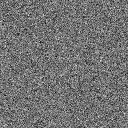

In [6]:
geoimage.image = np.random.randn(128, 128)
display(geoimage.image)

or as 3D `numpy.ndarray` for 3-band RGB image:

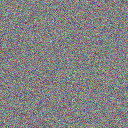

In [7]:
geoimage = GeoImage.create(workspace, image=np.random.randn(128, 128, 3))
display(geoimage.image)

The object can easily be saved back out to file with.

In [ ]:
geoimage.save_as("my_image.jpg")

A GeoImage can also be created directly from file (png, jpeg, tiff).

In [8]:
geoimage = GeoImage.create(workspace, image="my_image.jpg")

A `PIL.Image` object gets exposed to the user, which can be used for common raster manipulation (rotation, filtering, etc). The modified raster is stored back on file as a blob (`bytes`).

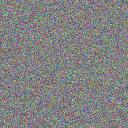

In [9]:
display(geoimage.image)

### Geo-referencing
By default, the `GeoImage` object will be displayed at the origin (xy-plane) with dimensions equal to the pixel count. The utility function [GeoImage.georeference](../api/geoh5py.objects.rst#geoh5py.objects.geo_image.GeoImage.georeference) lets users geo-reference the image in 3D space based on at least three (3) input reference points (pixels) with associated world coordinates.

In [ ]:
pixels = [
    [18, 73],
    [757, 1014],
    [18, 1014],
]
coords = [[311005, 6065252, 0], [320001, 6076748, 0], [311005, 6076748, 0]]

geoimage.georeference(pixels, coords)
print(geoimage.vertices)

## Grid2D


The `Grid2D` object defines a regular grid of `cells` often used to display model sections or to compute data derivatives.
A `Grid2D` can be oriented in 3D space using the `origin`, `rotation` and `dip` parameters.

In [ ]:
from geoh5py.objects import Grid2D


# Create the Surface object
grid = Grid2D.create(
    workspace,
    origin=[25, -75, 50],
    u_cell_size=2.5,
    v_cell_size=2.5,
    u_count=64,
    v_count=16,
    rotation=90.0,
    dip=45.0,
)

![grid2d](./images/grid2d.png)

## DrapeModel

The `DrapeModel` object defines an array of vertical (curtain) cells draped below a curved trace. 

- The `prisms` attribute defines the elevation and position of the uppermost cell faces.
- The `layers` attribute defines the bottom face elevation of cells. 

In the example below we create a simple `DrapeModel` object along a sinusoidal path with equal number of layers below every station. Variable number of layers per prism is also supported.


In [ ]:
from geoh5py.objects import DrapeModel


# Define a simple trace
n_columns = 32
n_layers = 8

x = np.linspace(0, np.pi, n_columns)
y = np.cos(x)
z = np.linspace(0, 1, n_columns)

# Count the index and number of values per columns
layer_count = np.ones(n_columns) * n_layers
prisms = np.c_[x, y, z, np.cumsum(layer_count) - n_layers, layer_count]

# Define the index and elevation of draped cells
k_index, i_index = np.meshgrid(np.arange(n_layers), np.arange(n_columns))
z_elevation = z[i_index] - np.linspace(0.5, 2, n_layers)

layers = np.c_[i_index.flatten(), k_index.flatten(), z_elevation.flatten()]

# Create the object
drape = DrapeModel.create(workspace, prisms=prisms, layers=layers)

![drapemodel](./images/drapemodel.png)

## BlockModel


The ``BlockModel`` object defines a rectilinear grid of cells, also known as a tensor mesh. The `cells` center position is determined by `cell_delimiters` (offsets) along perpendicular axes (`u`, `v`, `z`) and relative to the `origin`. ``BlockModel`` can be oriented horizontally by controlling the `rotation` parameter. 

In [ ]:
from geoh5py.objects import BlockModel


mesh = BlockModel.create(
    workspace,
    origin=[25, -100, 50],
    u_cell_delimiters=np.cumsum(np.ones(16) * 5),  # Offsets along u
    v_cell_delimiters=np.cumsum(np.ones(32) * 5),  # Offsets along v
    z_cell_delimiters=np.cumsum(np.ones(16) * -2.5),  # Offsets along z (down)
    rotation=30.0,
)

![blockmodel](./images/blockmodel.png)

Data values stored on the BlockModel object, such as `centroid` coordinates, are stored in [`w`, `u`, `v`] `Fortran` ordering. The 1D arrays can be resorted as 3D arrays with

In [ ]:
x = mesh.centroids[:, 0]
array = x.reshape((mesh.shape[2], mesh.shape[0], mesh.shape[1]), order="F")
print(array.shape)

The 3D array can be flatten back to 1D with

In [ ]:
array.flatten(order="F")

### Octree


The ``Octree`` object is type of 3D grid that uses a tree structure to define `cells`. Each cell can be subdivided it into eight octants allowing for a more efficient local refinement of the mesh. The ``Octree`` object can also be oriented horizontally by controlling the `rotation` parameter. 

In [ ]:
from geoh5py.objects import Octree


octree = Octree.create(
    workspace,
    origin=[25, -100, 50],
    u_count=16,  # Number of cells in power 2
    v_count=32,
    w_count=16,
    u_cell_size=5.0,  # Base cell size (highest octree level)
    v_cell_size=5.0,
    w_cell_size=2.5,  # Offsets along z (down)
    rotation=30,
)

By default, the octree mesh will be refined at the lowest level possible along each axes.

![octree](./images/octree.png)

In [ ]:
workspace.close()